## 라이브러리 버전을 확인해 봅니다
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.utils import shuffle
print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


# 데이터를 준비하자
💡 호옥시라도 웹캠이 없다면?

일단은 아래 내용을 쭉 읽고 숙지해주세요! 웹캠이 없는 경우 라는 토글에서 기다리고 있겠습니다. 물론 웹캠이 있다면 꼭 아래 내용을 따라해주세요 😉

🔶 데이터 만들기
(1) 우리는 노트북 전면 카메라를 활용하여 가위, 바위, 보 이미지 각 100장을 만들어 볼거예요. 그런데 300장을 어느 세월에 만들까요?

걱정하지 마세요. 구글의 teachable machine 사이트에서 쉽게 데이터를 만들어볼 수 있습니다. 아래 사이트에서 Get Started 버튼을 눌러보세요. 그 다음, Image Project - Standard image model을 선택하면, Webcam을 구동해 클래스별 이미지 데이터를 직접 촬영해서 만들 수 있는 멋진 화면이 나타납니다.

https://teachablemachine.withgoogle.com/

(2) 먼저 가위 이미지 데이터를 만들어 봅시다. 웹캠 앞에 가위 포즈를 취하면서 <Hold to Record> 버튼을 누르면 이미지가 캡쳐됩니다. 딥러닝 모델이 인식하기 좋게끔 여러분들 손이 잘 보이게 찍어주세요.

여러 각도에서 찍어보세요.
여러 크기로 찍어보세요.
혼자하면 다양한 각도와 크기를 저장할 수 없으니, 옆 동료와 함께 하세요.
좋은 데이터가 좋은 결과를 낳는다는 것을 꼭 기억하세요.

## 데이터 불러오기 + Resize 하기

(5) 숫자 손글씨의 경우 이미지 크기가 28x28 이었기 때문에, 우리의 가위, 바위, 보 이미지도 28x28로 만들어야 합니다. 이를 위해서는 PIL 라이브러리를 사용해볼 거예요. 그러려면 먼저 라이브러리를 불러와야 겠죠?

In [2]:
from PIL import Image
import glob
import os

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


이제 가위 이미지를 불러와서 28x28 사이즈로 변경할 겁니다. 아래 코드를 실행해보세요. 이미지의 크기가 28x28 로 바뀌었나요?

In [3]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

503  images to be resized.
503  images resized.
가위 이미지 resize 완료!


자 그러면, 바위 
이미지도 28x28 로 만들어 볼까요? 아래 빈 칸에 코드를 작성하고, 실행해보세요. 바위 이미지가 모두 28x28로 바뀌어야 합니다.

In [4]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

501  images to be resized.
501  images resized.
바위 이미지 resize 완료!


마지막으로 보 이미지도 28x28로 만들어 봅시다.

In [5]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

502  images to be resized.
502  images resized.
보 이미지 resize 완료!


(6) 숫자 손글씨 인식기는 mnist.load_data() 라는 함수로 데이터를 읽었던 것 기억하시죠? 여러분들이 아직 코딩에 익숙하지 않을 수 있으므로, 가위, 바위, 보 데이터를 읽을 수 있는 load_data() 함수를 만들어 드릴 거예요. 이 코드를 활용하면 임의의 사진 데이터(ex. 귤이 잘 익었나, 안 익었나? 웃는 얼굴인가, 우는 얼굴인가, 평범한 표정의 얼굴인가? 등)에 적용하실 수 있을 겁니다.

load_data() 함수는 입력으로 이미지가 있는 폴더 위치를 받습니다. 여기서는 rock_scissor_paper 폴더 위치를 적어주면 됩니다. 숫자 손글씨는 0~9 까지의 클래스가 있었던 것 기억하시죠? 가위바위보의 경우 3개의 클래스 즉, 가위: 0, 바위: 1, 보: 2 로 라벨링이 될 것입니다.

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(img_path, number_of_data=1506):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train,x_val,y_train ,y_val = train_test_split(x_train,y_train,
                                                test_size=0.2,
                                                 shuffle=True,
                                                random_state=2023)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇개인지 출력합니다.
print("전체 학습 데이터: {} 레이블: {}".format(x_train.shape, y_train.shape))
print("검증 데이터: {} 레이블: {}".format(x_val.shape, y_val.shape))

#정규화 합니다.
x_train = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화
x_val = x_val/255.0

print("x_train shape: {}".format(x_train.shape))
print("x_val shape: {}".format(x_val.shape))

학습데이터(x_train)의 이미지 개수는 1506 입니다.
전체 학습 데이터: (1204, 28, 28, 3) 레이블: (1204,)
검증 데이터: (302, 28, 28, 3) 레이블: (302,)
x_train shape: (1204, 28, 28, 3)
x_val shape: (302, 28, 28, 3)


한번 이미지를 불러 볼까요?

라벨:  2


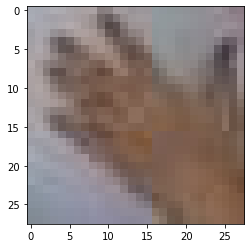

In [7]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

In [8]:
464+466+460

1390

# 딥러닝 네트워크 설계하기
자 이제 데이터의 준비가 끝났습니다. 이제 여러분들이 가위바위보를 인식하는 딥러닝 네트워크를 설계해 볼까요?

In [9]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?
# [[YOUR CODE]]
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

Model에 추가된 Layer 개수:  7


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

# 딥러닝 네트워크 학습시키기
잘 설계가 되었다면, 이제 학습을 시켜봅시다. 아마도 여러분들의 데이터는 거의 비슷비슷할 것이기 때문에 accuracy가 꽤 높게 나올 것입니다.

In [11]:
from tensorflow.keras import callbacks

check_point_cb = callbacks.ModelCheckpoint('sequential', 
                                           save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=13, 
                                            monitor='val_accuracy',
                                            restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=200,
                    validation_data=(x_val, y_val),
                    callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/200
38/38 [==============================] - 3s 10ms/step - loss: 1.0886 - accuracy: 0.4161 - val_loss: 1.0806 - val_accuracy: 0.5066
INFO:tensorflow:Assets written to: sequential/assets
Epoch 2/200
38/38 [==============================] - 0s 4ms/step - loss: 1.0777 - accuracy: 0.4610 - val_loss: 1.0707 - val_accuracy: 0.4139
INFO:tensorflow:Assets written to: sequential/assets
Epoch 3/200
38/38 [==============================] - 0s 4ms/step - loss: 1.0655 - accuracy: 0.4909 - val_loss: 1.0604 - val_accuracy: 0.4536
INFO:tensorflow:Assets written to: sequential/assets
Epoch 4/200
38/38 [==============================] - 0s 4ms/step - loss: 1.0523 - accuracy: 0.5664 - val_loss: 1.0403 - val_accuracy: 0.6490
INFO:tensorflow:Assets written to: sequential/assets
Epoch 5/200
38/38 [==============================] - 0s 4ms/step - loss: 1.0337 - accuracy: 0.5565 - val_loss: 1.0192 - val_accuracy: 0.5033
INFO:tensorflow:Assets written to: sequential/assets
Epoch 6/200
38/38 [==========

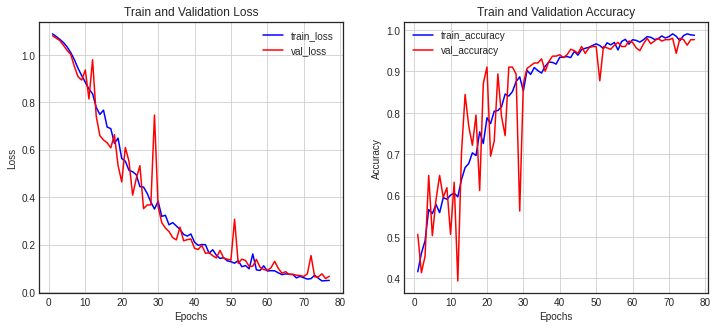

In [12]:
#시각화

plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

# 얼마나 잘 만들었는지 확인하기(테스트)
여러분들은 300장의 가위바위보 이미지를 만들어 모두 학습에 사용했습니다. 그러므로 테스트 데이터가 없죠. 옆 친구의 이미지 데이터 300장을 받아오세요. 그리고 그것을 테스트 데이터로 하여 test accuracy를 측정해보세요. (만약 웹캠이 없는 경우 섹션을 진행하신 경우, 이미 test 데이터셋이 준비돼있으니 친구에게 조르지 않으셔도 됩니다)

In [13]:
# x_test, y_test를 만드는 방법은 x_train, y_train을 만드는 방법과 아주 유사합니다.
# [[YOUR CODE]]
# 그냥 데이터를 왕창 모아서 val만 스플릿함수를 쓰기로했다
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")


100  images to be resized.
100  images resized.
가위 이미지 resize 완료!


In [14]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
바위 이미지 resize 완료!


In [15]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

100  images to be resized.
100  images resized.
보 이미지 resize 완료!


In [16]:
def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("테스트데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_data(image_dir_path)
x_test = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화



테스트데이터(x_test)의 이미지 개수는 300 입니다.


In [17]:
print("학습 데이터: {} 레이블: {}".format(x_train.shape, y_train.shape))
print("테스트 데이터: {} 레이블: {}".format(x_test.shape, y_test.shape))

학습 데이터: (1204, 28, 28, 3) 레이블: (1204,)
테스트 데이터: (300, 28, 28, 3) 레이블: (300,)


In [18]:
# 테스트 데이터셋을 이용해 모델을 평가합니다.
model.evaluate(x_test, y_test)

10/10 [==============================] - 0s 6ms/step - loss: 1.5116 - accuracy: 0.5267


[1.5116157531738281, 0.5266666412353516]

사이즈를 바꿔보자.

In [19]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 244x244 사이즈로 바꾸어 저장합니다.
	target_size=(128,128)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

503  images to be resized.
503  images resized.
가위 이미지 resize 완료!


In [20]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)

501  images to be resized.
501  images resized.


In [21]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)

502  images to be resized.
502  images resized.


In [22]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor"
resize_images(image_dir_path)

100  images to be resized.
100  images resized.


In [23]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock"
resize_images(image_dir_path)

100  images to be resized.
100  images resized.


In [24]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
resize_images(image_dir_path)

100  images to be resized.
100  images resized.


In [26]:
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(img_path, number_of_data=1506):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=128
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train,x_val,y_train ,y_val = train_test_split(x_train,y_train,
                                                test_size=0.2,
                                                 shuffle=True,
                                                random_state=2023)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇개인지 출력합니다.
print("전체 학습 데이터: {} 레이블: {}".format(x_train.shape, y_train.shape))
print("검증 데이터: {} 레이블: {}".format(x_val.shape, y_val.shape))

#정규화 합니다.
x_train = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화
x_val = x_val/255.0

print("x_train shape: {}".format(x_train.shape))
print("x_val shape: {}".format(x_val.shape))

학습데이터(x_train)의 이미지 개수는 1506 입니다.
전체 학습 데이터: (1204, 128, 128, 3) 레이블: (1204,)
검증 데이터: (302, 128, 128, 3) 레이블: (302,)
x_train shape: (1204, 128, 128, 3)
x_val shape: (302, 128, 128, 3)


In [27]:
def load_data(img_path, number_of_data=1390):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=128
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("테스트데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_data(image_dir_path)
x_test = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

테스트데이터(x_test)의 이미지 개수는 300 입니다.


라벨:  2


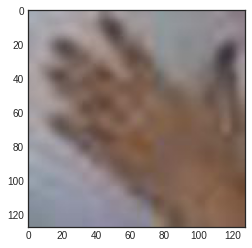

In [51]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

In [45]:
# 바꿔 볼 수 있는 하이퍼파라미터들
n_channel_1=8
n_channel_2=16
n_channel_3=64
n_dense_1=8
n_dense_2=4
n_dense_3=4
n_train_epoch=40
batchsize = 32


model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu',padding='same', input_shape=(128,128,3)))
model.add(layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(layers.Dropout(0.2))

model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))

model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))

model.add(keras.layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(keras.layers.Dense(n_dense_1, activation='relu'))
model.add(keras.layers.Dense(n_dense_2, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()
optimize=tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimize,
              metrics='accuracy')

# 모델 훈련
history = model.fit(x_train, y_train, epochs=n_train_epoch,
                validation_data=(x_val, y_val),
                batch_size =batchsize,
                 shuffle=True)
                
                

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 128, 128, 8)       224       
_________________________________________________________________
batch_normalization_26 (Batc (None, 128, 128, 8)       32        
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
batch_normalization_27 (Batc (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 32, 32, 16)       

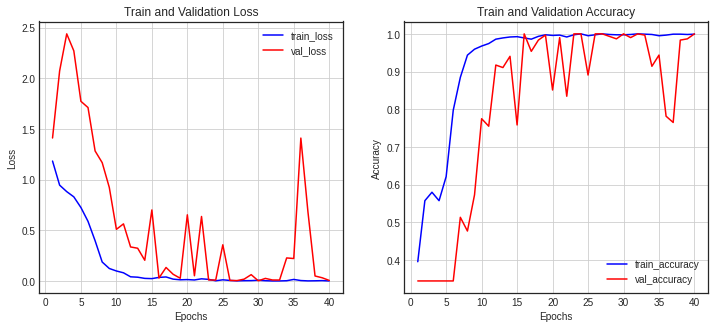

In [46]:
#시각화

plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [150]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

44/44 - 0s - loss: 0.8970 - accuracy: 0.8899
test_loss: 0.8969772458076477 
test_accuracy: 0.8899280428886414


In [60]:
predicted_result = model.predict(x_test)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [9.9996758e-01 3.2473145e-05 1.7180168e-14]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


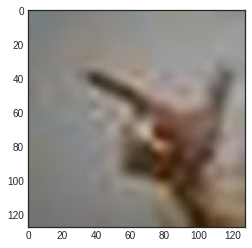

In [61]:
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

0은 가위고, 모델이 예측한건 가위기때문에, 잘 된 것 같다.

model.predict() 결과 :  [1.6911920e-06 9.9999833e-01 3.3491094e-08]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  1


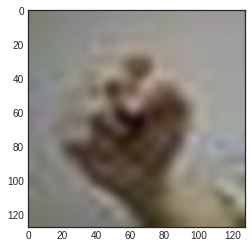

In [63]:
idx1=130
print('model.predict() 결과 : ', predicted_result[idx1])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx1])
print('실제 데이터의 라벨 : ', y_test[idx1])
plt.imshow(x_test[idx1],cmap=plt.cm.binary)
plt.show()

model.predict() 결과 :  [6.806008e-05 5.843344e-04 9.993476e-01]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  2


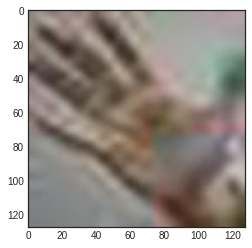

In [149]:
idx2=211
print('model.predict() 결과 : ', predicted_result[idx2])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx2])
print('실제 데이터의 라벨 : ', y_test[idx2])
plt.imshow(x_test[idx2],cmap=plt.cm.binary)
plt.show()

예측확률분포: [9.9669039e-01 3.3095381e-03 2.1842739e-09]
라벨: 1, 예측결과: 0


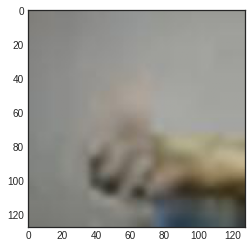

예측확률분포: [9.3658018e-01 6.3419402e-02 4.4719735e-07]
라벨: 2, 예측결과: 0


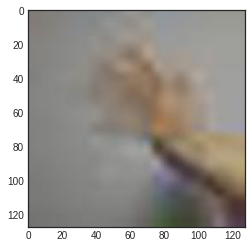

예측확률분포: [9.9938357e-01 6.1640586e-04 5.7412197e-13]
라벨: 2, 예측결과: 0


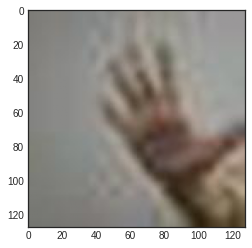

예측확률분포: [0.00294301 0.5975493  0.39950767]
라벨: 2, 예측결과: 1


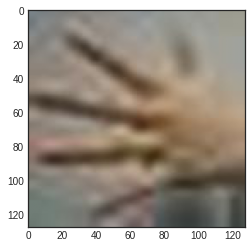

예측확률분포: [9.5047313e-01 4.9524684e-02 2.1406047e-06]
라벨: 2, 예측결과: 0


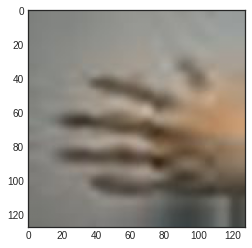

In [104]:
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

틀린것만 넣었기때문에 잘된것같기도하다.

# 회고

개인적으로 재밌어서 10시간이상 걸린 프로젝트기도 하다.

잘못된..(?) 테스트 데이터를 넣었더니 예측률이 현저히 떨어져서 무난한 테스트 데이터를 넣어서 정확도가 향상되는 모습을 보았다.

좀더 데이터를 넣는다면 좀더 정확한 모델이 나올 것 같다.

모델평가에 정확한 많은양의 데이터는 좀더 좋은 모델을 만들수 있다.


``` 좀더공부해야한다.```
